# Presenting monthly updates results

#### Ensure the correct version of the mapper is installed. Version 1.4.0 as of 8/24/2022

Run "pip install views_mapper2 --upgrade" if out of date


Note to team: multiple functionalities have been introduced. However, not all have been been presented in their complete bredth. Full review of the new mapper upcoming. 

Additionaly, to reduce the load in the looping, several functions that identify violence type from variable name and the dictionary to choose have been created. For these functions to work properly, the violence type should be documented as a final portion of variable description. Additionally, the log trasformation should be placed at the beginning of a variable name. 

e.g. ged_best_sb = state based violence non transformed, ln1_ged_best_sb = single log transformed state based violence

In [1]:
!pip freeze | grep views-mapper2

# Defining universals and obtain the data

In [3]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

import warnings
warnings.filterwarnings('ignore')

# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *

# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
sys.path.append('../SystemUpdates')
from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated
from FetchData import FetchData, RetrieveFromList
from ViewsEstimators import *

In [4]:
# Common parameters:
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#note the home path has been automated with the os.path.expanduser function
#no need to adjust the folder as long as ViEWS on the dropbox is the destination

import os
home = os.path.expanduser("~")
Mydropbox = home + '/Dropbox (ViEWS)/ViEWS/'
Monthly_updates = Mydropbox + 'DataReleases/MonthlyUpdates/'

In [5]:
# Read in future predictions as given by the parameters above
#note that the output step combined is already log transformed

predstore_future = level +  '_' + 'genetic_ensemble' + '_f' + str(EndOfHistory)
predstore_future_dich = level +  '_' + 'genetic_ensemble' + '_dich_f' + str(EndOfHistory)

predictions_df = pd.DataFrame.forecasts.read_store(predstore_future, run=dev_id)
predictions_dich_df = pd.DataFrame.forecasts.read_store(predstore_future_dich, run=dev_id)

#Redefine month_id into steps as a index, change the name of some variables for consistency/workability with code
#note step combined is already a log transformed variable that uses state-based violence
predictions_df = predictions_df.reset_index()
predictions_df['step'] = predictions_df['month_id'] - EndOfHistory
predictions_df = predictions_df.set_index(['step', 'country_id'], drop = True)
predictions_df['ln1_step_combined_sb'] = predictions_df['step_combined']
predictions_df['ln2_step_combined_sb'] = np.log1p(predictions_df['ln1_step_combined_sb'])

#predictions_dich_df gives state based violence
predictions_dich_df = predictions_dich_df.reset_index()
predictions_dich_df['step'] = predictions_dich_df['month_id'] - EndOfHistory
predictions_dich_df = predictions_dich_df.set_index(['step', 'country_id'], drop = True)
predictions_dich_df['step_combined_sb'] = predictions_dich_df['step_combined']

pr_46_cm_genetic_ensemble_f509.parquet
pr_46_cm_genetic_ensemble_dich_f509.parquet


# Maps country-month level

In [7]:
#import the necessary programs for mapping
import geopandas as gpd
import sqlalchemy as sa
from ingester3.config import source_db_path

from views_mapper2.mapper2 import *

from views_mapper2.dictionary_writer import *
from views_mapper2.BBoxWriter import *
from views_mapper2.label_writer import *

In [8]:
#specify the directory for saving output
#change the directory name to correspond to the run description (no need for malika_test_ in final version)

#per the notation describtion file, the primary foldername should be in the 
    #[label][version]_[YYYY]_[MM]_t[#of tries] format
#label: model classifier
#'version': model setup

#it would be nice to have this information as a download available in a standardized fashion
#to ensure that the correct/latest version of a model is used
#at this time I am using the common parameters previously established

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'


label_version = dev_id + '_' + 'genetic'
foldername = label_version+'_'+prod_id
folderpath = Monthly_updates + 'malika_test_' +foldername
make_folders_complete_set(folderpath)

Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01 already exists
Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/ActualAtEndOfHistory already exists
Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/Dichotomous already exists
Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/Dichotomous/Ensemble already exists
Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/Dichotomous/Ensemble/ForecastMaps already exists
Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/Dichotomous/Ensemble/ChangeMaps already exists
Directory /Users/havardhegre1/Drop

In [9]:
#obtaining the geometry for the data
engine = sa.create_engine(source_db_path)
gdf_ci_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as country_id, name, in_africa, in_me, geom FROM prod.country",
    engine,
    geom_col='geom'
)
gdf_ci_master = gdf_ci_master.to_crs(4326)

## Map of the actuals for the EndOfHistory Month

Below provides a loop for producing multiple types of maps at different geographies, etc. in a single run
Note that the greying out requires a separate process so I show it off separately and store in a new subfolder
This may be especially useful for single country presentations
Zoom out maps could not be implemented within the mapper, but the zoom out map can be created for layering within overleaf as separate entities to be combined later

per the request actuals and ranked order functions have been created as well for the following notebook

In [10]:
#fetch the actuals for the EndOfHistory
from viewser import Queryset, Column

queryset = (Queryset("actuals_monthly", "country_month")
            # CONFLICT TYPES NOT LOGGED and NOT time lagged
            .with_column(Column("ged_best_sb", from_table="ged2_cm", from_column="ged_sb_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            
            .with_column(Column("ged_best_ns", from_table="ged2_cm", from_column="ged_ns_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            
            .with_column(Column("ged_best_os", from_table="ged2_cm", from_column="ged_os_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            # .with_column(Column('name', from_table='country', from_column= 'name')
            # the above does not seem to want to work

            .with_theme("fatalities")

            .describe("""Fatalities conflict history, cm level
            
            Monthly update

            """)

            )

actuals = queryset.publish().fetch()

 .    

In [11]:
#List the top 10 countries name and country id
#note input month_id to obtain the value for that month, in the current example using the EndOfHistory
#function requires (dataset, month_id, column)
display(give_me_top10_names(actuals, EndOfHistory, 'ged_best_sb'))
display(give_me_top10_country_id(actuals, EndOfHistory, 'ged_best_sb'))

#for a more general function that also allows for cumulative top X determination use
#give_me_topX_country_id_cumulative(df, time_index, number_wanted, variable, start, end)
#df = dataframe, time_index = what is the name of the time_index, number_wanted = specifies what X top you want
#variable = variable of interest, start - time start, end = time end

#note how the same output can be achieved for a single month using the more general function

display(give_me_topX_country_id_cumulative(df = actuals, time_index = 'month_id', number_wanted = 10, 
                                           variable = 'ged_best_sb', start = EndOfHistory, end = EndOfHistory))
display(give_me_topX_country_names_cumulative(df = actuals, time_index = 'month_id', number_wanted = 10, 
                                           variable = 'ged_best_sb', start = EndOfHistory, end = EndOfHistory))

['Burkina Faso',
 'Mali',
 'Iraq',
 'Niger',
 'Nigeria',
 'Ukraine',
 'Somalia',
 'Afghanistan',
 'Myanmar',
 'Congo, DRC']

[47, 50, 60, 78, 79, 117, 120, 133, 149, 167]

[47, 50, 60, 78, 79, 117, 120, 133, 149, 167]

['Burkina Faso',
 'Mali',
 'Iraq',
 'Niger',
 'Nigeria',
 'Ukraine',
 'Somalia',
 'Afghanistan',
 'Myanmar',
 'Congo, DRC']

### Below is a loop for multiple different output combinations. Would you mind choosing your favorite and then we can limit the output to the ones preferred most

In [12]:
#transform data to create both log1 and log2 transformed versions of the variable
#please note that common parameters are borrowed from the top

#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'


#actuals data transformation
actuals['ln1_ged_best_sb'] = np.log1p(actuals['ged_best_sb'])
actuals['ln2_ged_best_sb'] = np.log1p(actuals['ln1_ged_best_sb'])

actuals['ln1_ged_best_ns'] = np.log1p(actuals['ged_best_ns'])
actuals['ln2_ged_best_ns'] = np.log1p(actuals['ln1_ged_best_ns'])

actuals['ln1_ged_best_os'] = np.log1p(actuals['ged_best_os'])
actuals['ln2_ged_best_os'] = np.log1p(actuals['ln1_ged_best_os'])

#note that you can both create custom or use pre-made dictionaries 
#some pre-made options are:
#dictionary_stand, dictionary_stand1p, dictionary_stand_1p_10k, dictionary_stand2p, dictionary_stand2p_10k
#display to view

#specify the primary savefolder of interest
ActualsMapFolder = folderpath + '/ActualAtEndOfHistory/'

#prep data
data= actuals.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing, in this case we are only interested in EndOfHistory
steps_loop = [EndOfHistory] 

#specify steps of interest and variables of interest
#I am running just a couple of examples as this outputs quite a lot
#specifics can be chosen permanently when we choose the best ones
variable_loop = {'ged_best_sb', 'ln1_ged_best_ns', 'ln2_ged_best_os'}


#specify regions to map
#requires either pre-set names like globe, ame or africa, or country_id in a numerical/integer format
#if you do not know country_id, can use a country_id identifying function
#name_mid2cid takes country name as string and month_id as integer
#name_date2cid takes country name as string and date as iso_string
geo_coverage_loop = ['globe', 'ame', name_mid2cid('Ukraine', EndOfHistory), name_date2cid('Nigeria', '2022-08-01')]


#transparency setting, on a 0-100% value, 0 for invisible and 1 for 100% opacity
transparency_loop = [0.3,1]

#background, there are many options but this is a sample of a couple
#some contain labels that overlay the map (StamenLite, StamenWatercolor, CartoDBPositron, CartoDBVoyager)
#some contain background and names, so if something over the top will be difficult to see but works well with transparency less than 1
#OpenTopoMap, OpenStreetMap, StamenTerrain
#StamenTerrainBackground has no labels and only terrain map
#some combinations have been made but if you wish to see different background add them below
background_loop = [None, 'StamenLite', 'StamenTerrainBackground']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        bbox_run = bbox_from_cid(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined
                        #requires one string of the variable name and 3 choices of dictionaries, can use custom ones here
                        #however they should be listed in the following order, dictionary_0 for standard dictionary
                        #dictionary_log1 for log transformed dictionary, and dictionary_log2 for log2 transformed dictionary
                        #in this case I am using some preset dictionaries rather than defining new ones
                        #refer to mapper2 github for example code of customized dictionary creators
                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results and avoid collision of labels
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 15
                            
                            
                        #the following adjusts the size of the textbox, may need to be modified if the size of the output is changed
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Actual fatalities in {str(vid2date(step))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ActualsMapFolder}ActualsMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_s0_month{step}_{dict_run_name}_trans{transparency_run}_{background_run}.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='rainbow',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)

### Presentation of masked versions of maps, requested for africa, ame and country level

There are two potential methods to create the masked/greyed out maps. One to use two layers. The other is to use mask with a background tile. Below is a loop to showcase the layered approach. These can be used to assemble the pop out maps for regions or avoid distraction of outside region countries. 

Please note that I used binary to achieve the greyed outlook, but if you leave the rainbow, you get a sense of other country results but washed out. Change the cmap in the first layer code to 'rainbow' from binary to see the effect. 

In [13]:
#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#specify the primary savefolder of interest, note new one created for ease of review of output
#alternatively, can be saved directly in the Actuals folder
ActualsMapFolder = folderpath + '/ActualAtEndOfHistory/'
ActualsMapFolderMasked = ActualsMapFolder+'Masked'
make_a_folder(ActualsMapFolderMasked)

#prep data
data= actuals.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing, in this case we are only interested in EndOfHistory
steps_loop = [EndOfHistory] 

#specify steps of interest and variables of interest
variable_loop = {'ged_best_sb', 'ln1_ged_best_ns', 'ln2_ged_best_os'}


#specify regions to map, change to any suggestions
geo_coverage_loop = ['africa', 'ame', name_mid2cid('Ukraine', EndOfHistory)]


#transparency setting, on a 0-100% value
transparency_loop = [0.3, 0.9]

#background, there are many options but this is a sample of a couple
background_loop = [None, 'StamenTerrainBackground', 'OpenTopoMap']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        
                        #note that since a slightly more zoomed out version of map was requested for this application
                        #use the bbox creator region that makes a slightly larged bbox
                        bbox_run = bbox_from_cid_region(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 10
                            
                            
                        #the following adjusts the size of the textbox
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Actual fatalities in {str(vid2date(step))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ActualsMapFolderMasked}/ActualsMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_s0_month{step}_{dict_run_name}_trans{transparency_run}_{background_run}_masked.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='binary',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run   
                        ).add_mask(
                            gdf = data_run,
                            map_dictionary = dict_run,
                            cmap = 'rainbow',
                            transparency = 1,
                            masking_location = region_name,
                            column=var_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size,
                            edgecolor="black",
                            linewidth=1,
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)

Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/ActualAtEndOfHistory/Masked already exists


## Continuous maps, PredictionMaps

In [14]:
#display top 10, at step 6 
display(give_me_top10_names(predictions_df, (EndOfHistory+6), 'ln1_step_combined_sb'))
display(give_me_top10_country_id(predictions_df, (EndOfHistory+6), 'ln1_step_combined_sb'))

#alternatively
display(give_me_topX_country_id_cumulative(df = predictions_df, time_index = 'step', number_wanted = 10, 
                                           variable = 'ln1_step_combined_sb', start = 6, end = 6))
display(give_me_topX_country_names_cumulative(df = predictions_df, time_index = 'step', number_wanted = 10, 
                                           variable = 'ln1_step_combined_sb', start = 6, end = 6))

['Burkina Faso',
 'Iraq',
 'Nigeria',
 'Ukraine',
 'Somalia',
 'Yemen',
 'Afghanistan',
 'Myanmar',
 'Congo, DRC',
 'Syria']

[47, 60, 79, 117, 120, 124, 133, 149, 167, 220]

[47, 60, 79, 117, 120, 124, 133, 149, 167, 220]

['Burkina Faso',
 'Iraq',
 'Nigeria',
 'Ukraine',
 'Somalia',
 'Yemen',
 'Afghanistan',
 'Myanmar',
 'Congo, DRC',
 'Syria']

In [15]:
#recursive run for Ensemble, forecast maps

#specify the primary savefolder of interest
ContinuousEnsembleForecastMapFolder = folderpath + '/Continuous/Ensemble/ForecastMaps/'

#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#prep data
data= predictions_df.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing
#note that since we defined index as step, steps are used in this case
steps_loop = [1, 6] 

#specify steps of interest and variables of interest
variable_loop = {'ln1_step_combined_sb', 'ln2_step_combined_sb'}


#specify regions to map
geo_coverage_loop = ['globe', 'ame', name_mid2cid('Iraq', EndOfHistory), name_date2cid('Burkina Faso', '2022-08-01')]


#transparency setting, on a 0-100% value
transparency_loop = [0.3,1]

#background, there are many options but this is a sample of a couple
background_loop = [None, 'StamenLite', 'StamenTerrainBackground']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        month_id_run = step + EndOfHistory
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        bbox_run = bbox_from_cid(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined
                        #requires one string of the variable name and 3 choices of dictionaries, can use custom ones here
                        #however they should be listed in the following order, dictionary_0 for standard dictionary
                        #dictionary_log1 for log transformed dictionary, and dictionary_log2 for log2 transformed dictionary
                        #in this case I am using some preset dictionaries
                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 15
                            
                            
                        #the following adjusts the size of the textbox
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Predicted continuous fatalities in {str(vid2date(month_id_run))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_s{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ContinuousEnsembleForecastMapFolder}PredictionMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_step{step}_month{month_id_run}_{dict_run_name}_trans{transparency_run}_{background_run}.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='rainbow',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)

In [16]:
#prediction maps with masked out locations

#specify the primary savefolder of interest, note new one created for ease of review of output
ContinuousEnsembleForecastMapFolder = folderpath + '/Continuous/Ensemble/ForecastMaps/'
ContinuousEnsembleForecastMapFolderMasked =ContinuousEnsembleForecastMapFolder +'Masked'
make_a_folder(ContinuousEnsembleForecastMapFolderMasked)

#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#prep data
data= predictions_df.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing, in this case we are only interested in EndOfHistory
steps_loop = [1, 6] 

#specify steps of interest and variables of interest
variable_loop = {'ln1_step_combined_sb', 'ln2_step_combined_sb'}


#specify regions to map
geo_coverage_loop = ['globe', 'ame', name_mid2cid('Iraq', EndOfHistory), name_date2cid('Burkina Faso', '2022-08-01')]

#transparency setting, on a 0-100% value
transparency_loop = [0.3, 0.9]

#background, there are many options but this is a sample of a couple
background_loop = [None, 'StamenTerrainBackground', 'OpenTopoMap']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        month_id_run = step + EndOfHistory
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        
                        #note that since a slightly more zoomed out version of map was requested for this application
                        #use the bbox creator region that makes a slightly larged bbox
                        bbox_run = bbox_from_cid_region(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 10
                            
                            
                        #the following adjusts the size of the textbox
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Predicted continuous fatalities in {str(vid2date(month_id_run))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_s{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ContinuousEnsembleForecastMapFolderMasked}/PredictionMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_s{step}_month{month_id_run}_{dict_run_name}_trans{transparency_run}_{background_run}_masked.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='binary',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run   
                        ).add_mask(
                            gdf = data_run,
                            map_dictionary = dict_run,
                            cmap = 'rainbow',
                            transparency = 1,
                            masking_location = region_name,
                            column=var_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size,
                            edgecolor="black",
                            linewidth=1,
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)


Directory /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/DataReleases/MonthlyUpdates/malika_test_Fatalities002_genetic_2022_04_t01/Continuous/Ensemble/ForecastMaps/Masked already exists


## Continuos, change maps

I am not sure how to obtain the data to make these maps possible, would someone mind adding data grabbing line below

In [17]:
#folder to save output
ContinuousChangeMaps = folderpath + '/Continuous/Ensemble/ChangeMaps/'

In [18]:
#obtain data

## Continous, ensemble line graphs

Per Jim's code, there is a section of the code where the Ensemblelist is used for modelname/data pull. Is there a way to do so without the EnsembleList use/fetch from internal storage? Alternatively, are there different line graphs wanted?

Additionally, note that the data starts only at step1 that was fetched from internal storage

In the meantime, this is the closest approximation of what I thought I could do for output

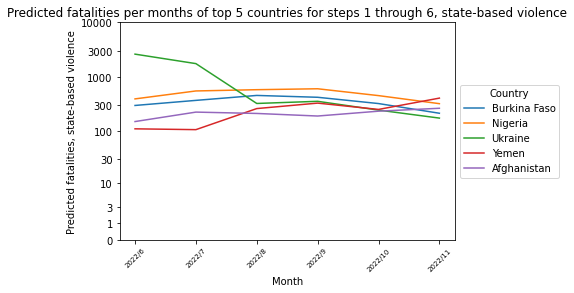

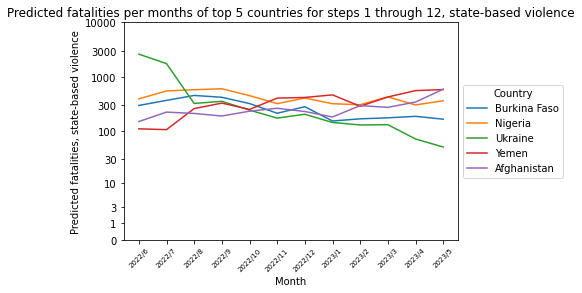

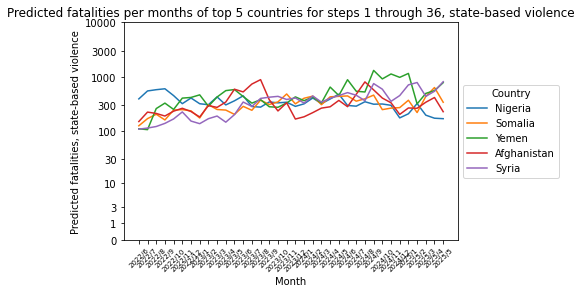

In [19]:
#potential alternative, linear graph of predicted fatalities from step1 to step36 for top 5 countries

#reference to the folder for saving output
ContinuousLineGraph = folderpath + '/Continuous/Ensemble/LineGraphs/'

#common parameters, borrowed from the top
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#define the data

data = predictions_df.copy()

#portion for looping and choosing the time wanted, e.g. 6 = want to graph step1-6 for top 5 countries in that same time period
steps_end_loop = [6, 12, 36]

#specify steps of interest and variables of interest
#note the main differences will be in sb or ns
variable_loop = {'ln1_step_combined_sb'}


for end_step in steps_end_loop:
    for variable in variable_loop:
        #portion that chooses the countries
        country_list_run = give_me_topX_country_id_cumulative(df = data, time_index = 'step', 
                                                              number_wanted = 5, variable = variable,
                                                              start = 1, end = end_step)
        
        #subset the data
        temporary_df = data.iloc[predictions_df.index.get_level_values('step') <= end_step]
        data_run = temporary_df[temporary_df.index.get_level_values('country_id').isin(country_list_run)].reset_index().set_index('step')
        
        #define the tags
        var_name_run = find_the_violence_type(variable)
        var_run_savefile = give_me_violence_string_label_only(variable)
        
        #define the scale for y axis
        dictionary_for_run = find_the_dictionary(variable, dictionary_0 = dictionary_stand_10k, 
                                                dictionary_log1 = dictionary_stand_1p_10k,
                                                dictionary_log2 = dictionary_stand_2p_10k)
        for dictionary_name, dictionary in dictionary_for_run.items():
            dict_run_name = dictionary_name
            dict_run = dictionary
        
        y_label = list(dict_run.keys())
        y_value = list(dict_run.values())
        
        #define the scale for x axis, add one before and one after the range of interest
        time_line_values=np.array(range(1, end_step+1, 1))
        time_line_names=[vid2date(i+EndOfHistory) for i in time_line_values]
        
    
        savefile = f'{ContinuousLineGraph}LineGraph_continuous_{level}{var_run_savefile}_{dev_id}_r{EndOfHistory}_top5_step1to{end_step}_{variable}.png'
        
        plt.figure()
        for i in list(data_run.groupby('country_id').groups.keys()):
            cdata= data_run.groupby('country_id').get_group(i)
            cdata[variable].plot(label=Country(i).name)
        
        plt.xticks(time_line_values, time_line_names, size = 7, rotation = 45)  
        plt.yticks(y_value, y_label)
        plt.legend(title='Country', loc=6, bbox_to_anchor=(1, 0.5))
            
        plt.title(f'Predicted fatalities per months of top 5 countries for steps 1 through {end_step}, {var_name_run}')
        plt.xlabel("Month")
        plt.ylabel(f"Predicted fatalities, {var_name_run}")
        
        plt.savefig(savefile, dpi=300)
        

## Continous, ensemble bar graphs and pie charts

Much like the other code, I am not sure how to get the model specific information without Ensemble. Additionally, would someone mind just jotting down a quick idea on what is wanted for this graph subtype

In [20]:
ContinuousBarCharts = folderpath + '/Continuous/Ensemble/BarCharts/'
ContinuousPieCharts = folderpath + '/Continuous/Ensemble/PieCharts/'

In [ ]:
#obtain the data



## Dichotomous graphs

TBA after review of above

Additionally, any notes on differences from the other graphs that are wanted for this subtype of outcome